# GPU info

In [1]:
!nvidia-smi

Thu May  1 21:43:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0             N/A /  200W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import

In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

import torchvision
import torchvision.transforms.v2 as T
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors

import segmentation_models_pytorch as smp
from torchmetrics import Dice, MeanMetric

from PIL import Image, ImageChops
from imageio import mimsave

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from glob import glob
from os import path, listdir, getcwd, makedirs
from typing import Optional, Callable

/home/yasin/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

# Device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Arguments

In [5]:
batch_size = 12
# dataset_root = path.join(getcwd(), "brain_mri_dataset/lgg-mri-segmentation/kaggle_3m")
dataset_root = path.join(getcwd(), "kaggle_3m_cleaned")

# Configs

# Helpers

In [6]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters() if p.requires_grad_])
    print(f"The number of trainable parameters: {params:,}")

In [7]:
def create_df_phase(phase_file="train.txt"):
    phase_file = phase_file.lower()
    
    assert phase_file in ["train.txt", "eval.txt", "test.txt"], "Phase_file must be one of [train.txt, eval.txt, test.txt]"
    
    with open(path.join(getcwd(), phase_file), 'r') as f:
        train_ids = f.read()
        f.close()
        train_ids = train_ids.split(', ')
        
        selected_columns = ["patient_id", "slice", "slice_path"]
        
        df_train = df_images[df_images.patient_id.isin(train_ids)][selected_columns].copy()
        df_train = df_train.merge(df_masks[df_masks.patient_id.isin(train_ids)][selected_columns], on=["patient_id", "slice"])
        
        df_train.rename(columns={"slice_path_x": "img_path", "slice_path_y": "msk_path"}, inplace=True)
        
        df_train.to_csv(path.join(getcwd(), phase_file.replace("txt", "csv")), index=False)

In [8]:
def train_one_epoch(dataloader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device):
    model.train()

    metric_fn.reset()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

            trange.set_postfix(loss=avg_loss, metric=avg_metric)

    return model, avg_loss, avg_metric

In [9]:
def eval_one_epoch(dataloader, model, loss_fn, metric_fn, avg_fn, device):
    model.eval()

    metric_fn.reset()
    avg_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

        print(f"Eval ==> loss: {avg_loss:.4}\tmetric: {avg_metric:.4}\n")

    return avg_loss, avg_metric

In [10]:
def combined_loss_fn(preds, target, alpha=0.7):
    dice_loss = smp.losses.DiceLoss(mode="binary", ignore_index=0)
    bce_loss = nn.BCEWithLogitsLoss()

    return alpha * dice_loss(preds, target) + (1 - alpha) * bce_loss(preds, target.to(torch.float32))

# Data

## Primary overview to the dataset

In [11]:
paths = glob(path.join(dataset_root, "**"), recursive=True)
paths = list(filter(lambda x: x.endswith(".tif"), paths))

len(paths)

7230

In [12]:
paths[:5]

['/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_43.tif',
 '/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_10_mask.tif',
 '/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_24.tif',
 '/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_45_mask.tif',
 '/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23_mask.tif']

In [13]:
paths[0].split(path.sep)[-1].split('_')

['TCGA', 'DU', '6401', '19831001', '43.tif']

In [14]:
paths[1].split(path.sep)[-1].split('_')

['TCGA', 'DU', '6401', '19831001', '10', 'mask.tif']

In [15]:
df = pd.read_csv(path.join(dataset_root, "data.csv"))

In [16]:
df.describe()

RNASeqCluster  MethylationCluster  miRNACluster   CNCluster  \
count      92.000000          109.000000    110.000000  108.000000   
mean        2.445652            3.678899      1.900000    1.722222   
std         1.180092            1.169684      0.789263    0.862872   
min         1.000000            1.000000      1.000000    1.000000   
25%         1.000000            3.000000      1.000000    1.000000   
50%         2.000000            4.000000      2.000000    1.000000   
75%         4.000000            5.000000      2.000000    3.000000   
max         4.000000            5.000000      4.000000    3.000000   

       RPPACluster  OncosignCluster  COCCluster  histological_type  \
count    98.000000       105.000000  110.000000         109.000000   
mean      2.367347         1.895238    1.763636           2.128440   
std       1.125045         0.663960    0.855927           0.850935   
min       1.000000         1.000000    1.000000           1.000000   
25%       1.000000         1.000000    1.000000           1.000000   
50%       2.000000         2.000000    1.000000           2.000000   
75%       3.000000         2.000000    3.000000           3.000000   
max       4.000000         3.000000    3.000000           3.000000   

       neoplasm_histologic_grade  tumor_tissue_site  laterality  \
count                 109.000000              109.0  109.000000   
mean                    1.532110                1.0    2.009174   
std                     0.501273                0.0    0.995317   
min                     1.000000                1.0    1.000000   
25%                     1.000000                1.0    1.000000   
50%                     2.000000                1.0    2.000000   
75%                     2.000000                1.0    3.000000   
max                     2.000000                1.0    3.000000   

       tumor_location      gender  age_at_initial_pathologic        race  \
count      109.000000  109.000000                 109.000000  108.000000   
mean         3.513761    1.486239                  45.834862    2.907407   
std          1.863960    0.502119                  13.797151    0.291212   
min          1.000000    1.000000                  20.000000    2.000000   
25%          2.000000    1.000000                  34.000000    3.000000   
50%          2.000000    1.000000                  47.000000    3.000000   
75%          6.000000    2.000000                  58.000000    3.000000   
max          6.000000    2.000000                  75.000000    3.000000   

        ethnicity     death01  
count  102.000000  109.000000  
mean     1.970588    0.247706  
std      0.169792    0.433674  
min      1.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    0.000000  
75%      2.000000    0.000000  
max      2.000000    1.000000

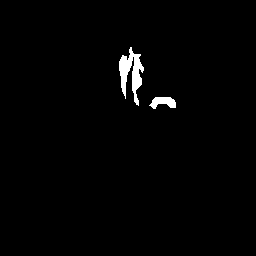

In [17]:
img = Image.open(paths[30])
img

In [18]:
img_t = T.functional.to_image(img)
*img_t.shape, str(img_t.dtype).replace("torch.", ''), img_t.min(), img_t.max().item()

(1, 256, 256, 'uint8', tensor(0, dtype=torch.uint8), 255)

In [57]:
a = path.join(dataset_root)
a

'/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned'

(torch.Size([3, 256, 256]),
 torch.uint8,
 tensor(0, dtype=torch.uint8),
 tensor(151, dtype=torch.uint8))

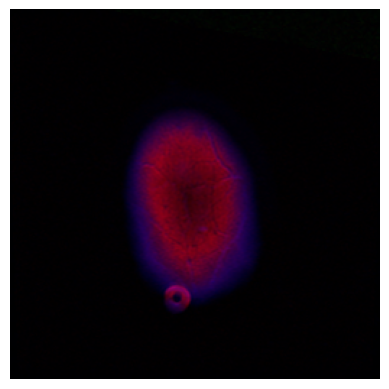

In [55]:
img = Image.open(a)
img = T.functional.to_image(img)
plt.imshow(img.permute(1, 2, 0))
plt.axis("off");

img.shape, img.dtype, img.min(), img.max()

## Data prepration

### Read data.csv

In [19]:
df_data = pd.read_csv(path.join(dataset_root, "data.csv"))

### Seperate images from their relevant masks

In [20]:
images_full_path = list(filter(lambda x: not x.endswith("_mask.tif"), paths))
masks_full_path = list(filter(lambda x: x.endswith("_mask.tif"), paths))

len(images_full_path), len(masks_full_path), images_full_path[0]

(3615,
 3615,
 '/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_43.tif')

### Make columns (patient_id, slice, slice_path, size, dtype, max_pixel)

In [21]:
images_info, masks_info = [], []

for img_path, msk_path in zip(images_full_path, masks_full_path):

    # Image
    img = Image.open(img_path)
    img = T.functional.to_image(img)
    patient_id, slice_date, slice_num = img_path.split(path.sep)[-1].replace(".tif", '').split('_')[-3:]
    img_info = [patient_id, int(slice_num), slice_date, img_path, *img.shape, str(img.dtype).replace("torch.", ''), img.max().item()]
    images_info.append(img_info)
    
    # Mask
    msk = Image.open(msk_path)
    msk = T.functional.to_image(msk)
    patient_id, slice_date, slice_num = msk_path.split(path.sep)[-1].split('_')[-4:-1]
    msk_info = [patient_id, int(slice_num), slice_date, msk_path, *msk.shape, str(img.dtype).replace("torch.", ''), msk.max().item()]
    masks_info.append(msk_info)

### Create dataframe for images and their relevant masks

In [22]:
columns_name = ["patient_id", "slice", "slice_date", "slice_path", "channel", "width", "height", "sample_dtype", "max_pixel"]

df_images = pd.DataFrame(images_info, columns=columns_name).sort_values(["patient_id", "slice"])
df_masks = pd.DataFrame(masks_info, columns=columns_name).sort_values(["patient_id", "slice"])

df_images

patient_id  slice slice_date  \
390        4941      1   19960909   
380        4941      2   19960909   
374        4941      3   19960909   
373        4941      4   19960909   
381        4941      5   19960909   
...         ...    ...        ...   
1154       A61B     71   19991127   
1152       A61B     72   19991127   
1123       A61B     73   19991127   
1175       A61B     74   19991127   
1137       A61B     75   19991127   

                                             slice_path  channel  width  \
390   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
380   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
374   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
373   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
381   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
...                                                 ...      ...    ...   
1154  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1152  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1123  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1175  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1137  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   

      height sample_dtype  max_pixel  
390      256        uint8        215  
380      256        uint8        219  
374      256        uint8        240  
373      256        uint8        255  
381      256        uint8        255  
...      ...          ...        ...  
1154     256        uint8         88  
1152     256        uint8         89  
1123     256        uint8         81  
1175     256        uint8         69  
1137     256        uint8         58  

[3615 rows x 9 columns]

## Create a GIF from a patient's scans

In [23]:
patient_id = "7881"

visual_img = df_images[df_images.patient_id == patient_id]
visual_msk = df_masks[df_masks.patient_id == patient_id]

imgs = []

for i, (img, msk) in enumerate(zip(visual_img.values, visual_msk.values)):
    img = Image.open(img[3])
    msk = Image.open(msk[3])

    res = ImageChops.add(img, msk.convert("RGB"))
    imgs.append(res)

makedirs(path.join(getcwd(), "images", "gifs"), exist_ok=True)
mimsave(path.join(getcwd(), "images", "gifs", f"{patient_id}.gif"), imgs, duration=100, loop=0)

## EDA

### data.csv dataframe (Additional information of all patients)

#### Gender

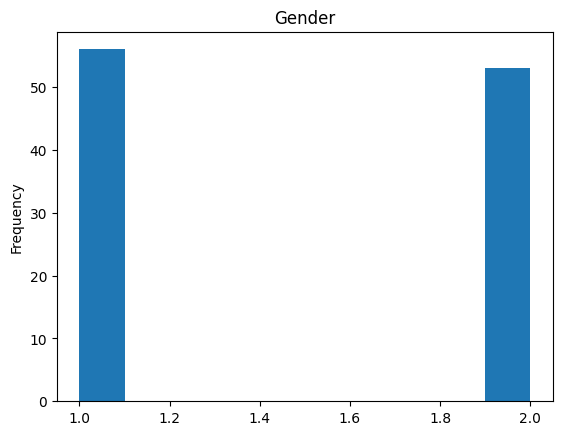

In [24]:
df_data.gender.plot(kind="hist", title="Gender");

#### Age at initial pathologic

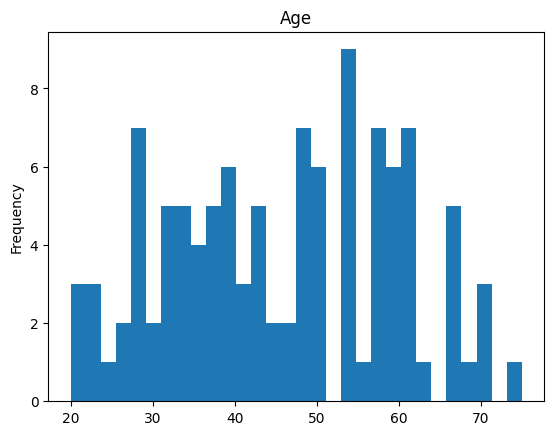

In [25]:
df_data.age_at_initial_pathologic.plot(kind="hist", title="Age", bins=30);

#### Race

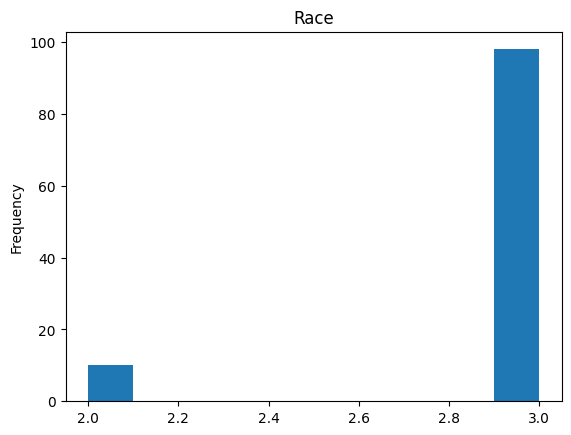

In [26]:
df_data.race.plot(kind="hist", title="Race");

#### Ethnicity

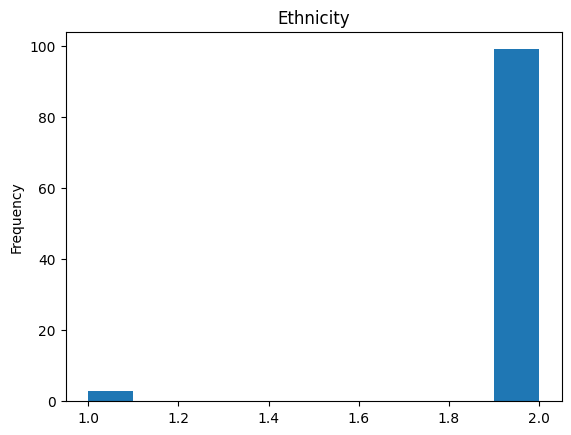

In [27]:
df_data.ethnicity.plot(kind="hist", title="Ethnicity");

#### Death Status

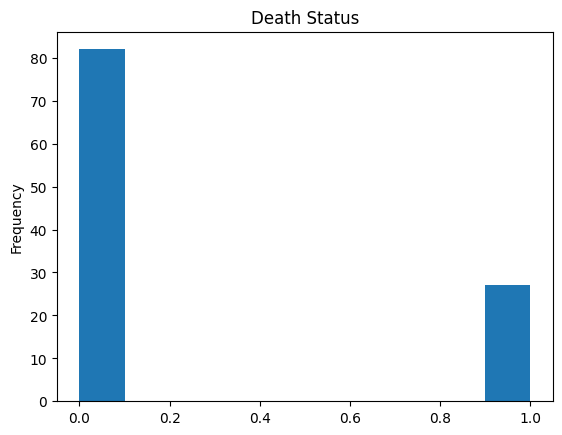

In [28]:
df_data.death01.plot(kind="hist", title="Death Status");

### Images dataframe

In [29]:
df_images

patient_id  slice slice_date  \
390        4941      1   19960909   
380        4941      2   19960909   
374        4941      3   19960909   
373        4941      4   19960909   
381        4941      5   19960909   
...         ...    ...        ...   
1154       A61B     71   19991127   
1152       A61B     72   19991127   
1123       A61B     73   19991127   
1175       A61B     74   19991127   
1137       A61B     75   19991127   

                                             slice_path  channel  width  \
390   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
380   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
374   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
373   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
381   /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
...                                                 ...      ...    ...   
1154  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1152  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1123  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1175  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   
1137  /home/yasin/Documents/projects/dl/brain_mri_se...        3    256   

      height sample_dtype  max_pixel  
390      256        uint8        215  
380      256        uint8        219  
374      256        uint8        240  
373      256        uint8        255  
381      256        uint8        255  
...      ...          ...        ...  
1154     256        uint8         88  
1152     256        uint8         89  
1123     256        uint8         81  
1175     256        uint8         69  
1137     256        uint8         58  

[3615 rows x 9 columns]

### Masks dataframe

In [30]:
df_masks

patient_id  slice slice_date  \
380        4941      1   19960909   
388        4941      2   19960909   
390        4941      3   19960909   
381        4941      4   19960909   
372        4941      5   19960909   
...         ...    ...        ...   
1108       A61B     71   19991127   
1106       A61B     72   19991127   
1176       A61B     73   19991127   
1114       A61B     74   19991127   
1138       A61B     75   19991127   

                                             slice_path  channel  width  \
380   /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
388   /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
390   /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
381   /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
372   /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
...                                                 ...      ...    ...   
1108  /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
1106  /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
1176  /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
1114  /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   
1138  /home/yasin/Documents/projects/dl/brain_mri_se...        1    256   

      height sample_dtype  max_pixel  
380      256        uint8          0  
388      256        uint8          0  
390      256        uint8          0  
381      256        uint8          0  
372      256        uint8          0  
...      ...          ...        ...  
1108     256        uint8          0  
1106     256        uint8          0  
1176     256        uint8          0  
1114     256        uint8          0  
1138     256        uint8          0  

[3615 rows x 9 columns]

### Sizes and dtype

In [31]:
df_images.channel.unique(), df_images.width.unique(), df_images.height.unique(), df_images.sample_dtype.unique()

(array([3]), array([256]), array([256]), array(['uint8'], dtype=object))

In [32]:
df_masks.channel.unique(), df_masks.width.unique(), df_masks.height.unique(), df_masks.sample_dtype.unique()

(array([1]), array([256]), array([256]), array(['uint8'], dtype=object))

### The number of pixels

In [33]:
df_images.max_pixel.min()

58

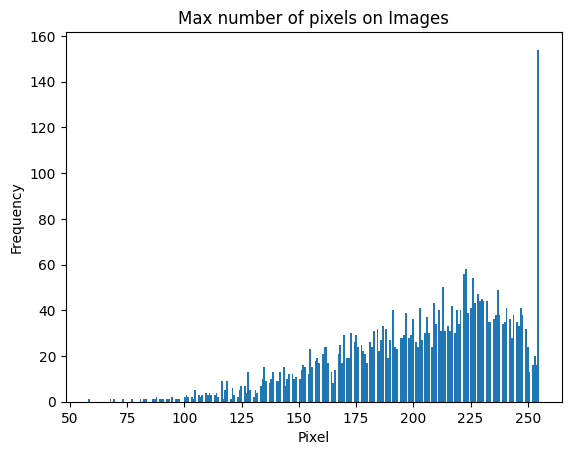

In [34]:
df_images.max_pixel.plot(kind="hist", title="Max number of pixels on Images", xlabel="Pixel", bins=255);

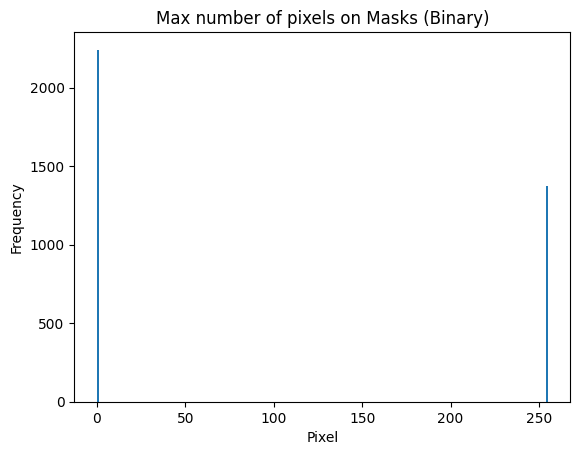

In [35]:
df_masks.max_pixel.plot(kind="hist", title="Max number of pixels on Masks (Binary)", xlabel="Pixel", bins=255);

### Visualize each channel separately

/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40.tif
/home/yasin/Documents/projects/dl/brain_mri_segmentation/kaggle_3m_cleaned/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_40_mask.tif 



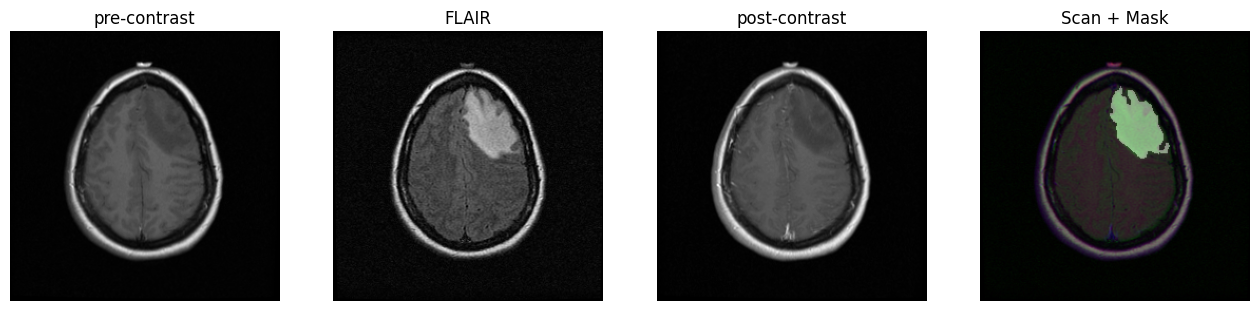

In [36]:
sample_idx = torch.randint(0, df_images.shape[0], (1,)).item()

img = Image.open(df_images.iloc[sample_idx].slice_path)
msk = Image.open(df_masks.iloc[sample_idx].slice_path)

print(df_images.iloc[sample_idx].slice_path)
print(df_masks.iloc[sample_idx].slice_path, "\n")

img = T.functional.to_image(img)
msk = T.functional.to_image(msk)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 7))

titles = ["pre-contrast", "FLAIR", "post-contrast", "Scan + Mask"]

axs[0].imshow(img[0], cmap="gray")
axs[1].imshow(img[1], cmap="gray")
axs[2].imshow(img[2], cmap="gray")

axs[3].imshow(img.permute(1, 2, 0), cmap="gray")
axs[3].imshow(msk.permute(1, 2, 0), cmap="gray", alpha=0.4)

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.axis("off");

## Split data to Train, Eval, and Test

In [37]:
train_set, eval_set, test_set = random_split(df_images.patient_id.unique(), lengths=[0.8, 0.1, 0.1])

with open(path.join(getcwd(), "train.txt"), 'w') as f:
    f.write(str(list(train_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()
    
with open(path.join(getcwd(), "eval.txt"), 'w') as f:
    f.write(str(list(eval_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()

with open(path.join(getcwd(), "test.txt"), 'w') as f:
    f.write(str(list(test_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()

len(train_set), len(eval_set), len(test_set)

(88, 11, 11)

## Create df_train, df_eval, and df_test

### Train dataframe

In [38]:
create_df_phase("train.txt")

### Eval dataframe

In [39]:
create_df_phase("eval.txt")

### Test dataframe

In [40]:
create_df_phase("test.txt")

## Implement custom dataset

In [41]:
class BrainMRIDataset(VisionDataset):
    def __init__(self, csv_file: str, transforms: Optional[Callable] = None, memory: Optional[bool] = False):
        super(BrainMRIDataset, self).__init__(transforms=transforms)

        self.df = pd.read_csv(csv_file)
        self.memory = memory

        self.img_ls = []
        self.msk_ls = []

        if memory:
            self._save_memory()
    
    def __getitem__(self, item_idx):

        if self.memory:
            img = self.img_ls[item_idx]
            msk = self.msk_ls[item_idx]
        else:
            patient_id, slice_, img_path, msk_path = self.df.iloc[item_idx]
    
            img = self._read_sample(img_path)
            msk = self._read_sample(msk_path, is_img=False)

        if self.transforms is not None:
            img, msk = self.transforms(img, msk)
        
        return img, msk.int()
    
    def _save_memory(self):
        for patient_id, slice_, img_path, msk_path in self.df.values:
            img = self._read_sample(img_path)
            self.img_ls.append(img)

            msk = self._read_sample(msk_path, is_img=False)
            self.msk_ls.append(msk)
    
    def _read_sample(self, path_, is_img=True):
        samp = Image.open(path_)
        samp = T.functional.to_image(samp)

        if is_img:
            samp = self._normalizer(samp)
            samp = tv_tensors.Image(samp)
        else:
            # samp = samp.repeat(3, 1, 1)
            samp = samp.float() / 255.0
            samp = tv_tensors.Mask(samp)

        return samp
    
    def _normalizer(self, x):
        return (x - x.min()) / (x.max() - x.min())
    
    def __len__(self):
        return self.df.shape[0]

## Transforms

In [42]:
train_trainsforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomPhotometricDistort(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(35),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

eval_trainsforms = T.Compose([
    T.Resize((256, 256)),
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [43]:
d = BrainMRIDataset("./train.csv", train_trainsforms, False)

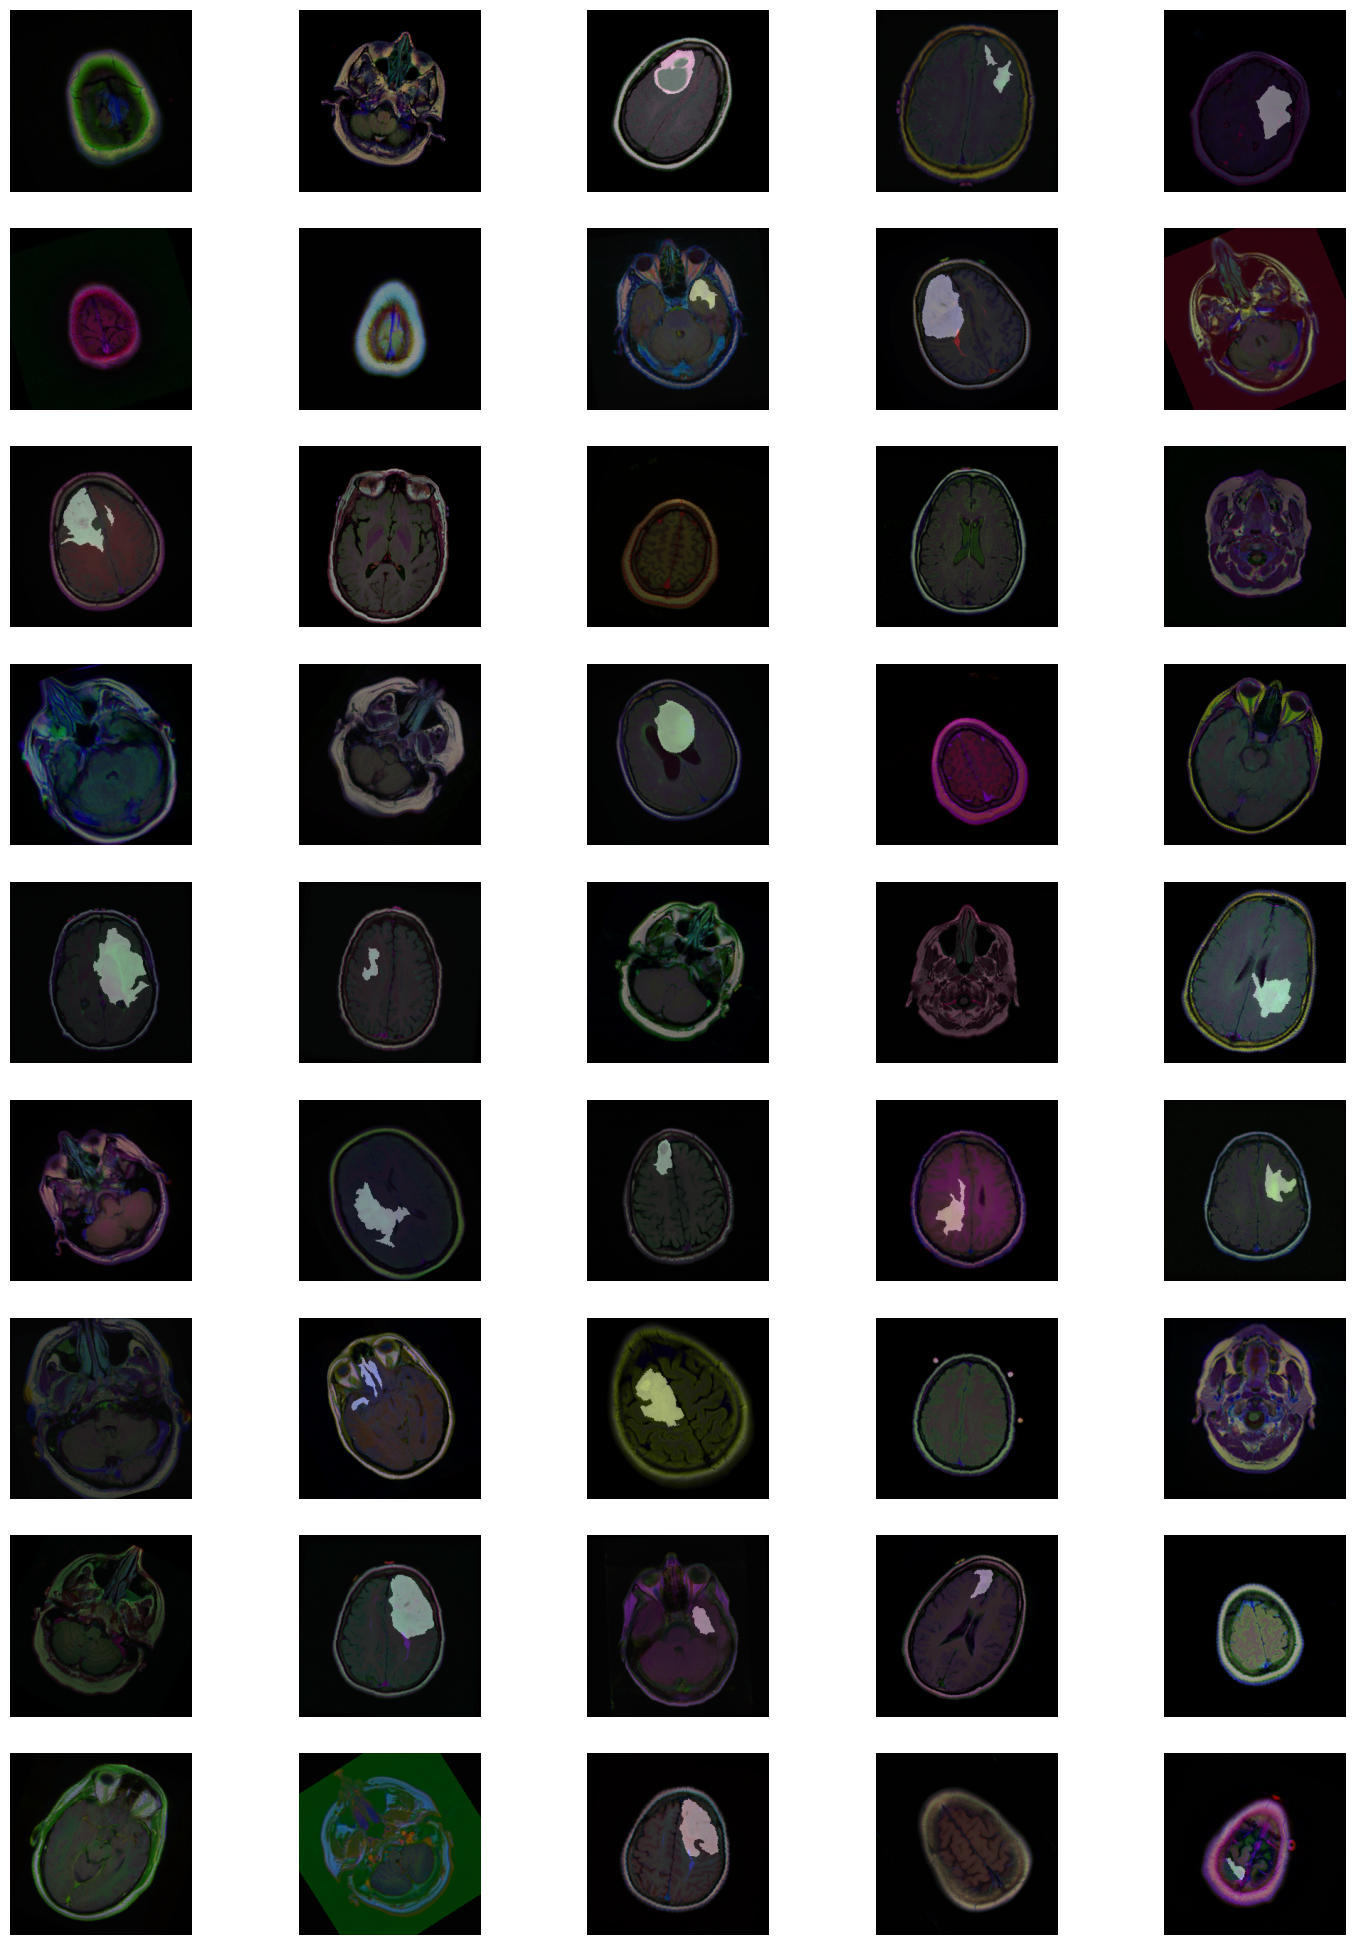

In [44]:
rand_idx = torch.randint(0, len(d), (45,))

fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(18, 25))
axs = axs.flatten()

for i, idx in enumerate(rand_idx):
    img_, msk_ = d[idx.item()]

    axs[i].imshow(img_.permute(1, 2, 0), cmap="gray")
    axs[i].imshow(msk_.permute(1, 2, 0), alpha=0.4, cmap="gray")

for ax in axs:
    ax.axis("off")

## Create datasets

In [45]:
train_set = BrainMRIDataset(path.join(getcwd(), "train.csv"), train_trainsforms, True)
eval_set = BrainMRIDataset(path.join(getcwd(), "eval.csv"), eval_trainsforms, True)
test_set = BrainMRIDataset(path.join(getcwd(), "test.csv"), eval_trainsforms, False)

len(train_set), len(eval_set), len(test_set)

(2798, 457, 360)

## Dataloaders

In [46]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=batch_size*2)
test_loader = DataLoader(test_set, batch_size=batch_size*2)

In [47]:
img, msk = next(iter(train_loader))
img.shape, msk.shape, msk.min(), msk.max(), msk.dtype, msk.unique()

(torch.Size([12, 3, 256, 256]),
 torch.Size([12, 1, 256, 256]),
 tensor(0, dtype=torch.int32),
 tensor(1, dtype=torch.int32),
 torch.int32,
 tensor([0, 1], dtype=torch.int32))

# Model

In [48]:
model = smp.Unet(encoder_name="efficientnet-b5", encoder_weights="imagenet", classes=1, in_channels=3)
num_parameters(model)

The number of trainable parameters: 31,216,001


# Train phase

## Check paths

### Forward

In [54]:
img, msk = next(iter(train_loader))

print(img.shape, img.min(), img.max())
print(msk.shape, msk.min(), msk.max())
with torch.inference_mode():
    yp = model(img)
    print(yp.shape, yp[0, ...].min(), yp[0, ...].max())
    loss = combined_loss_fn(yp, msk)

torch.cuda.empty_cache()

loss.item()

torch.Size([16, 3, 256, 256]) tensor(0.) tensor(1.)
torch.Size([16, 1, 256, 256]) tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)
torch.Size([16, 1, 256, 256]) tensor(-5.1086) tensor(15.6625)


0.4246821999549866

### Backward

In [57]:
model = smp.Unet(encoder_name="efficientnet-b1", encoder_weights="imagenet", classes=1, in_channels=3).to(device)
num_parameters(model)

The number of trainable parameters: 8,757,105


In [58]:
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [59]:
_, mini_train_set = random_split(train_set, lengths=[0.8, 0.2])
_, mini_eval_set = random_split(eval_set, lengths=[0.8, 0.2])

mini_train_loader = DataLoader(mini_train_set, batch_size=batch_size, shuffle=True)
mini_eval_loader = DataLoader(mini_eval_set, batch_size=batch_size)

len(mini_train_set), len(mini_eval_set)

(632, 63)

In [60]:
for ep in range(5):
    model, _, _ = train_one_epoch(mini_train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
    eval_one_epoch(mini_eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

torch.cuda.empty_cache()

Epoch 0: 100%|███████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.25s/ batch, loss=0.369, metric=0.0523]


Eval ==> loss: 0.3069	metric: 0.08249



Epoch 1: 100%|████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.25s/ batch, loss=0.231, metric=0.102]


Eval ==> loss: 0.2545	metric: 0.1099



Epoch 2: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/ batch, loss=0.18, metric=0.201]


Eval ==> loss: 0.2103	metric: 0.2197



Epoch 3: 100%|████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.25s/ batch, loss=0.147, metric=0.307]


Eval ==> loss: 0.1839	metric: 0.311



Epoch 4: 100%|████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/ batch, loss=0.123, metric=0.406]


Eval ==> loss: 0.1559	metric: 0.413



## Find efficient hyper-parameters

In [51]:
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [52]:
for lr in [0.00001, 0.0001, 0.0005, 0.001]:
    for wd in [0, 1e-5, 1e-4]:
        print(f"\nLR: {lr}, WD: {wd}")
        
        model = smp.Unet(encoder_name="efficientnet-b1", encoder_weights="imagenet", classes=1, in_channels=3).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

        for ep in range(3):
            model, _, _ = train_one_epoch(train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
            eval_one_epoch(eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

        torch.cuda.empty_cache()


LR: 1e-05, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.388, metric=0.0528]


Eval ==> loss: 0.3025	metric: 0.2451



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.291, metric=0.0735]


Eval ==> loss: 0.2168	metric: 0.1754



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.225, metric=0.102]


Eval ==> loss: 0.1911	metric: 0.2224


LR: 1e-05, WD: 1e-05


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.453, metric=0.033]


Eval ==> loss: 0.4154	metric: 0.08024



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.317, metric=0.0723]


Eval ==> loss: 0.2721	metric: 0.1358



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.247, metric=0.122]


Eval ==> loss: 0.2445	metric: 0.1736


LR: 1e-05, WD: 0.0001


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.396, metric=0.0455]


Eval ==> loss: 0.3832	metric: 0.07301



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.319, metric=0.074]


Eval ==> loss: 0.3056	metric: 0.1195



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.232, metric=0.104]


Eval ==> loss: 0.183	metric: 0.1767


LR: 0.0001, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.301, metric=0.0624]


Eval ==> loss: 0.1984	metric: 0.6202



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.142, metric=0.456]


Eval ==> loss: 0.1056	metric: 0.6204



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0858, metric=0.51]


Eval ==> loss: 0.07369	metric: 0.6079


LR: 0.0001, WD: 1e-05


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.261, metric=0.0885]


Eval ==> loss: 0.1523	metric: 0.5654



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.122, metric=0.439]


Eval ==> loss: 0.09256	metric: 0.5897



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0715, metric=0.511]


Eval ==> loss: 0.06392	metric: 0.689


LR: 0.0001, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.238, metric=0.101]


Eval ==> loss: 0.1612	metric: 0.5554



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.108, metric=0.445]


Eval ==> loss: 0.08549	metric: 0.629



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0622, metric=0.538]


Eval ==> loss: 0.05347	metric: 0.6955


LR: 0.0005, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0984, metric=0.256]


Eval ==> loss: 0.04381	metric: 0.6223



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.0358, metric=0.492]


Eval ==> loss: 0.03938	metric: 0.5473



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0254, metric=0.565]


Eval ==> loss: 0.03148	metric: 0.614


LR: 0.0005, WD: 1e-05


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.105, metric=0.251]


Eval ==> loss: 0.04537	metric: 0.6625



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0367, metric=0.479]


Eval ==> loss: 0.03673	metric: 0.6018



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0261, metric=0.566]


Eval ==> loss: 0.03301	metric: 0.5886


LR: 0.0005, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.108, metric=0.223]


Eval ==> loss: 0.05266	metric: 0.6147



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.0346, metric=0.483]


Eval ==> loss: 0.03947	metric: 0.569



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0303, metric=0.52]


Eval ==> loss: 0.03147	metric: 0.7124


LR: 0.001, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0772, metric=0.286]


Eval ==> loss: 0.04877	metric: 0.621



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0328, metric=0.476]


Eval ==> loss: 0.03499	metric: 0.6441



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0311, metric=0.478]


Eval ==> loss: 0.0335	metric: 0.7427


LR: 0.001, WD: 1e-05


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0887, metric=0.266]


Eval ==> loss: 0.04355	metric: 0.5563



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0392, metric=0.427]


Eval ==> loss: 0.03757	metric: 0.7337



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0259, metric=0.551]


Eval ==> loss: 0.02641	metric: 0.6909


LR: 0.001, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.102, metric=0.266]


Eval ==> loss: 0.3253	metric: 0.5022



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:11<00:00,  1.25s/ batch, loss=0.0402, metric=0.443]


Eval ==> loss: 0.07954	metric: 0.748



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:11<00:00,  1.24s/ batch, loss=0.0346, metric=0.461]


Eval ==> loss: 0.05475	metric: 0.7394



## Full Train

In [51]:
model = smp.Unet(encoder_name="efficientnet-b5", encoder_weights="imagenet", classes=1, in_channels=3).to(device)
num_parameters(model)

The number of trainable parameters: 31,216,001


In [52]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
schedular = MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [53]:
best_model = model
min_eval_loss = torch.inf

In [54]:
train_loss_hist, train_metric_hist = [], []
eval_loss_hist, eval_metric_hist = [], []

In [55]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(8):
    model, train_loss, train_metric = train_one_epoch(train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
    eval_loss, eval_metric = eval_one_epoch(eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

    if min_eval_loss > eval_loss:
        best_model = model
        min_eval_loss = eval_loss

    train_loss_hist.append(train_loss)
    eval_loss_hist.append(eval_loss)
    train_metric_hist.append(train_metric)
    eval_metric_hist.append(eval_metric)

    schedular.step()

end_time = datetime.now().replace(microsecond=0)

torch.cuda.empty_cache()

print(f"Comupation Time: {end_time - start_time}")

Epoch 0:   0%|                                                                                              | 0/243 [00:00<?, ? batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 13.38 MiB is free. Including non-PyTorch memory, this process has 3.92 GiB memory in use. Of the allocated memory 3.84 GiB is allocated by PyTorch, and 53.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Save the best model

In [54]:
torch.save(best_model.to("cpu"), path.join(getcwd(), "final_model.pt"))

## Plot

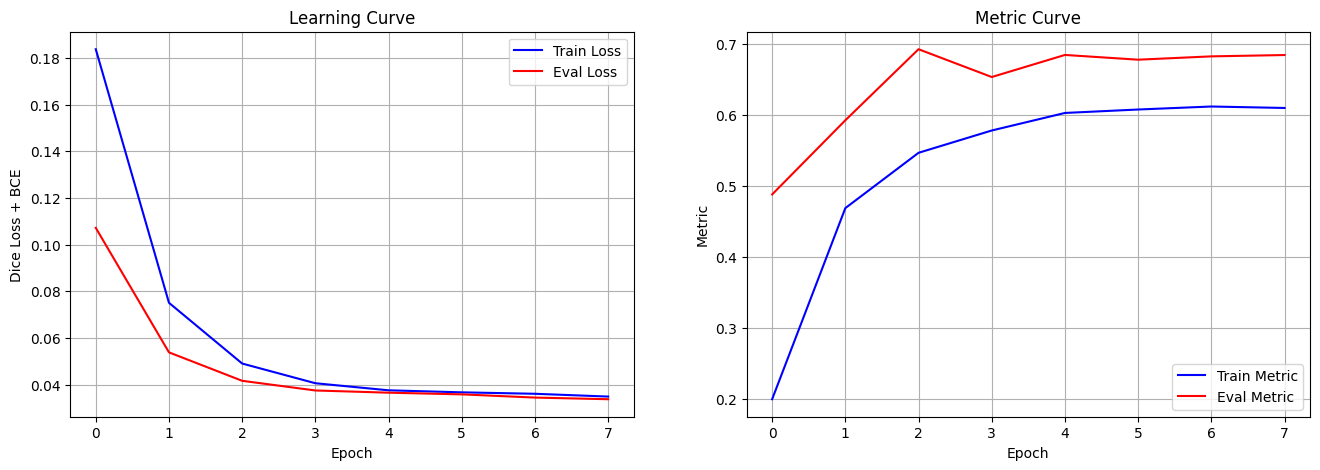

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axs[0].plot(train_loss_hist, c='b', label="Train Loss")
axs[0].plot(eval_loss_hist, c='r', label="Eval Loss")
axs[1].plot(train_metric_hist, c='b', label="Train Metric")
axs[1].plot(eval_metric_hist, c='r', label="Eval Metric")

axs[0].set_title("Learning Curve")
axs[0].set_ylabel("Dice Loss + BCE")
axs[1].set_title("Metric Curve")
axs[1].set_ylabel("Metric")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.grid()
    ax.legend()

# Test phase

In [56]:
final_model_loaded = torch.load(path.join(getcwd(), "final_model.pt"), weights_only=False)

In [58]:
with torch.inference_mode():
    final_model_loaded.to(device)
    test_loss, test_metric = eval_one_epoch(test_loader, final_model_loaded, combined_loss_fn, metric_fn, avg_fn, device)

torch.cuda.empty_cache()

Eval ==> loss: 0.02839	metric: 0.6772



# Segmentation phase

In [85]:
with torch.inference_mode():
    final_model_loaded.to("cpu")
    test_img, test_msk = next(iter(test_loader))

    yp = final_model_loaded(test_img)
    yp = torch.sigmoid(yp)

torch.cuda.empty_cache()

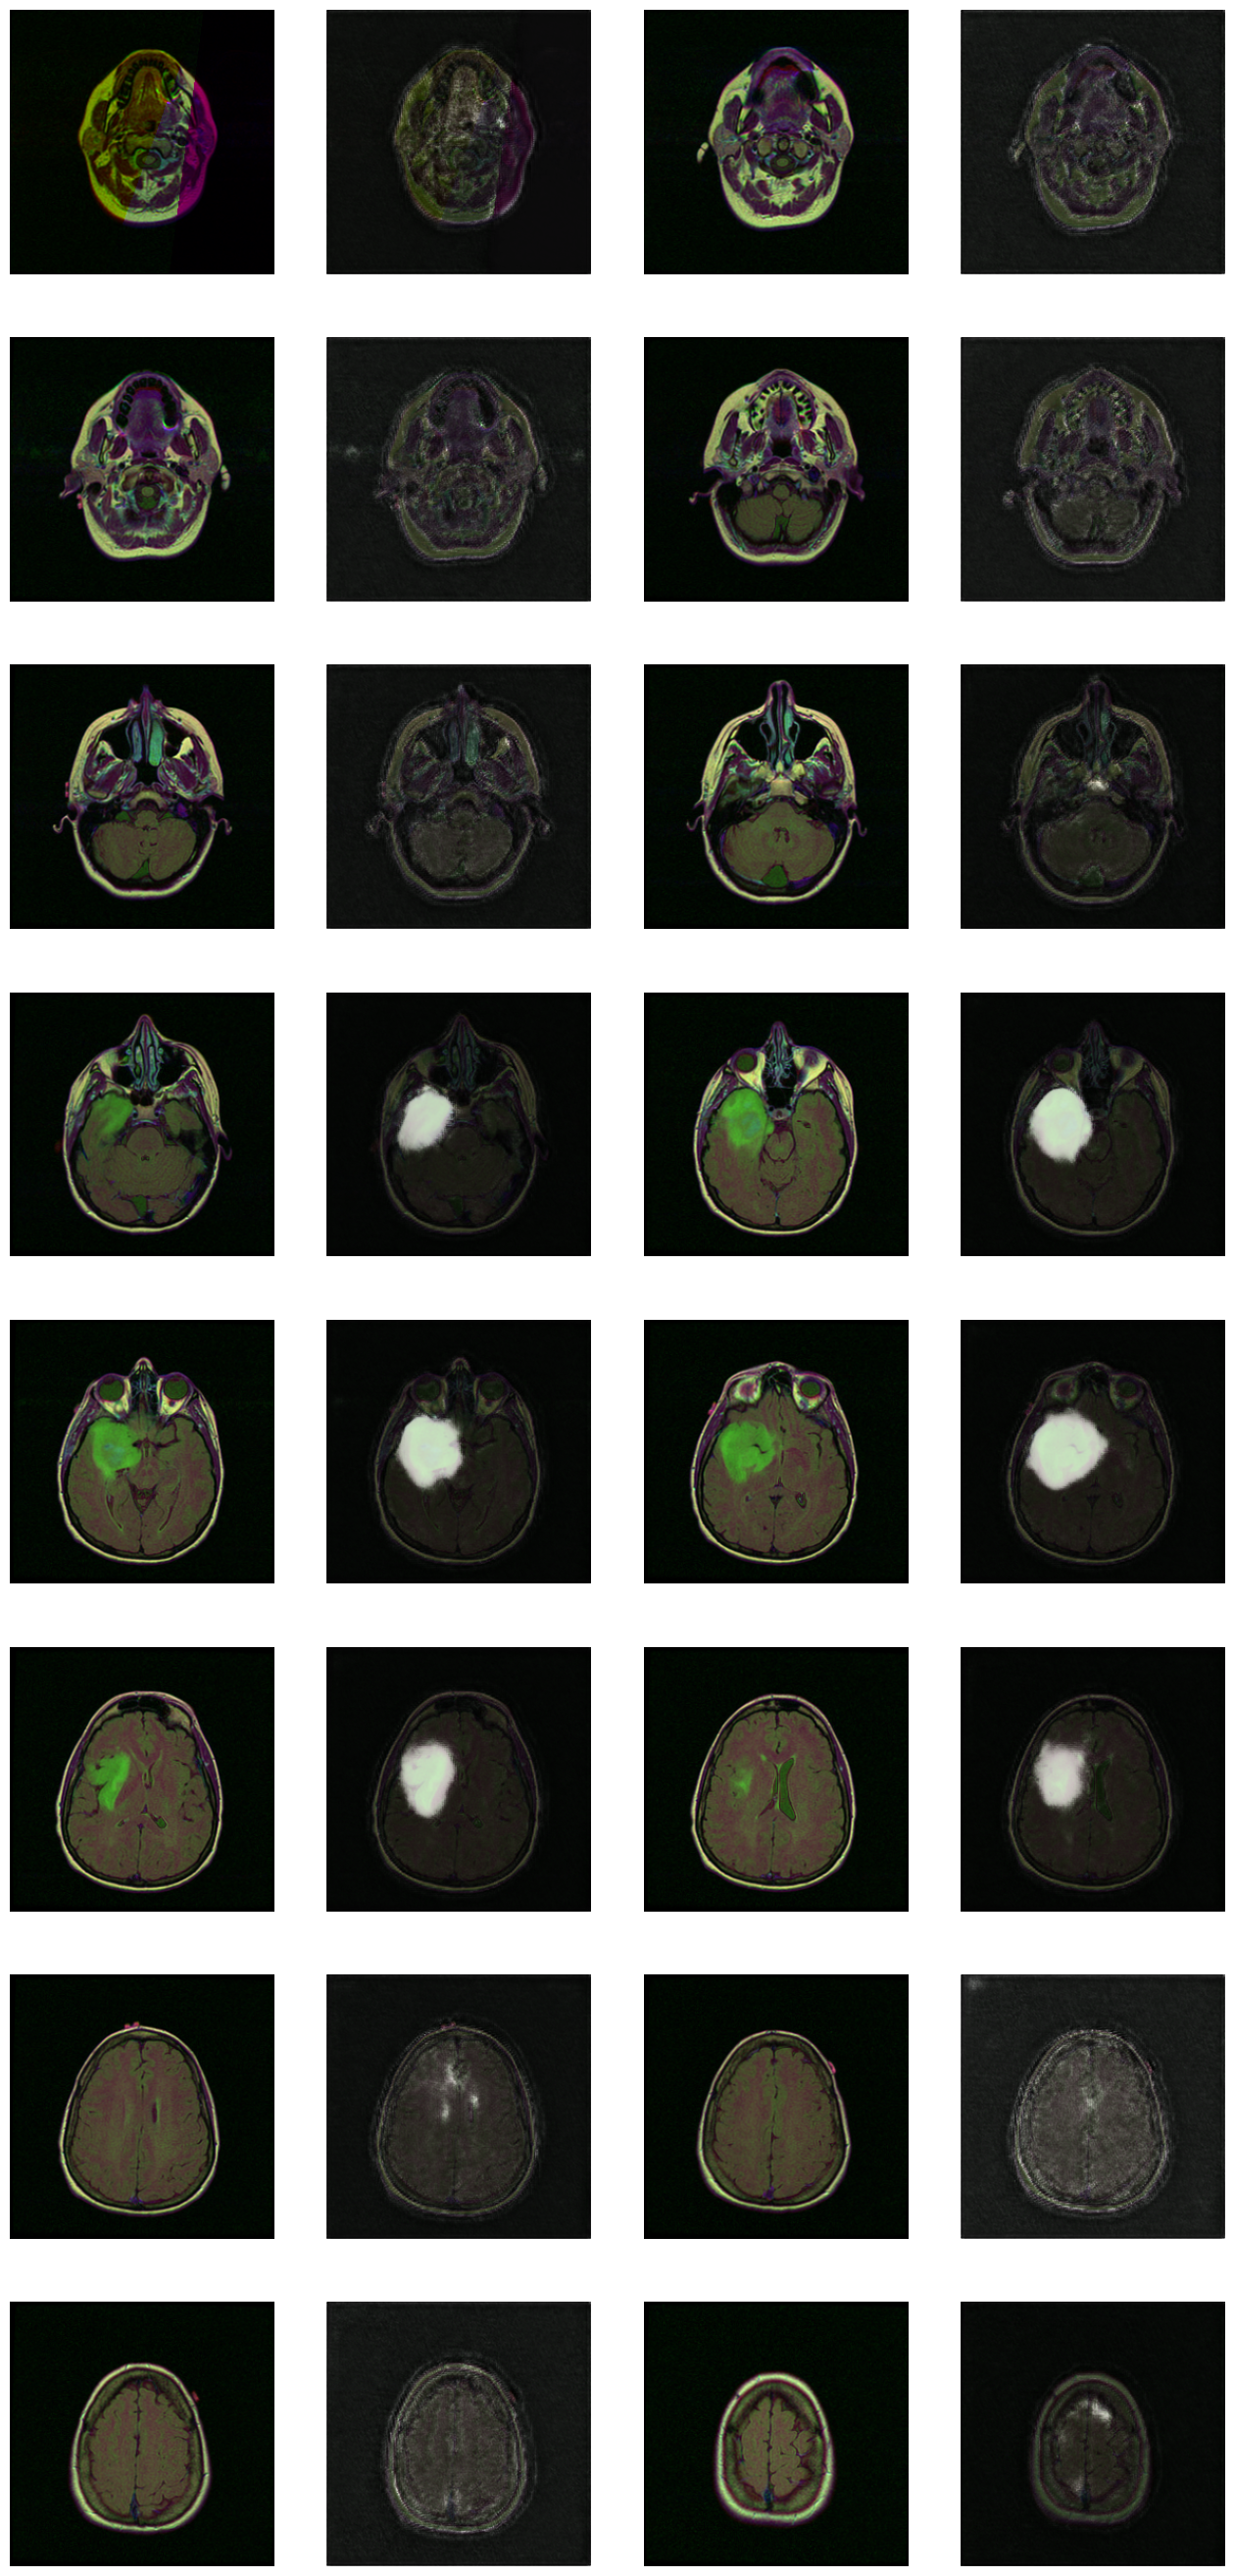

In [98]:
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(16, 34))
axs = axs.flatten()

for i in range(0, batch_size*2, 2):
    axs[i].imshow(test_img[i, ...].permute(1, 2, 0), cmap="gray")
    
    axs[i+1].imshow(test_img[i, ...].permute(1, 2, 0), cmap="gray")
    axs[i+1].imshow(yp[i, ...].permute(1, 2, 0), cmap="gray", alpha=0.7)
    
    axs[i].axis("off");
    axs[i+1].axis("off");